# Dynamic Hierarchical Clustering for Stocks

Clustering is an extremely useful technique in analyzing stocks.<br> We could use cluster to distinguish correlated stocks in order to reduce risk or gain alpha by hedging or neutralizing.<br> <br> Among the popular clustering methods (<a href="https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68">5 Popular Clustering Algos</a>), I prefer Hierarchical Clustering the most for stocks given it's consistency and outstanding performance. <br><br> Hierarchical clustering does not require us to prespecify the number of clusters like other algorithms and most hierarchical algorithms are deterministic. These advantages of hierarchical clustering come at the cost of lower efficiency. (<a href="https://nlp.stanford.edu/IR-book/html/htmledition/hierarchical-clustering-1.html#ch:hierclust">Hierarchical Clustering - Intro</a>) It should be fine in stock clustering as the number of labels (tickers) are limited. <br><br> However, we still have some struggles within Hierarchical Clustering, like how to tune the parameter to get the optimal number of clusters, how to define the appropriate distance, how to choose the best linkage method, etc. <br> <br> Below codes will show 2 existing algorithms and a new modified algorithm from myself to tackle with these kinds of issues when using Hierarchical Clustering for stocks. <br><br>The new modified algorithm could be an alternative and a new way to think about Hierarchical Clustering for stocks.

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.cluster import hierarchy as hc
from collections import Counter, OrderedDict

### Prepare Datasets
Latest S&P 500 universe will be used as an example. <br><br> Due to subscription issue, I will just scrape the current ticker list from Wikipedia and get the 3 Year historical price data from Quandl. Please refer to another ipynb file named <a href="https://github.com/kymanj/stock-clustering-algo/blob/master/Get%20S%26P%20Data.ipynb">Get S&P Data</a>. The script is just a slightly modified version from this link. (<a href="https://pythonprogramming.net/stock-price-correlation-table-python-programming-for-finance/">Special Thanks to PythonProgramming.net</a>) <br><br> Then, I calculated the daily return from this priceDf. <br><br> It's not perfect and I even didn't do filter on primary only stocks, if you have your own return datasets, you could import your file and skip this step. <br><br> The csv file is attached for illustration purpose.

In [2]:
priceDf = pd.read_csv('sp500_joined_closes.csv')
priceDf['Date'] = priceDf['Date'].astype('datetime64[ns]')
priceDf = priceDf.set_index('Date')
priceDf = priceDf.dropna(axis=1, how='any')

In [3]:
priceDf.tail()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-27,164.529999,81.839996,74.849998,175.889999,191.380005,52.330002,277.540009,28.719999,161.679993,16.309999,...,192.699997,108.250000,65.360001,30.330000,95.949997,80.129997,112.989998,134.130005,44.360001,123.900002
2019-09-30,164.399994,83.669998,75.720001,177.889999,192.350006,52.919998,276.250000,28.990000,165.399994,16.340000,...,192.970001,108.720001,64.889999,29.910000,95.900002,79.620003,113.430000,137.270004,44.520000,124.589996
2019-10-01,158.380005,81.839996,73.230003,170.210007,189.619995,52.900002,272.709991,28.760000,167.289993,16.240000,...,187.929993,109.919998,64.949997,29.469999,92.040001,76.830002,112.889999,133.610001,42.970001,125.120003
2019-10-02,155.649994,79.529999,72.129997,163.389999,184.850006,52.250000,266.660004,28.309999,162.960007,15.700000,...,184.210007,111.190002,63.340000,28.969999,92.449997,74.610001,112.669998,131.949997,42.259998,122.290001
2019-10-03,154.520004,80.919998,73.580002,163.854996,185.250000,54.650002,271.980011,28.360001,159.559998,15.860000,...,185.070007,109.260002,63.244999,29.080000,92.239998,74.669998,113.800003,132.559998,42.139999,124.339996


In [4]:
returnDf = priceDf.pct_change()

In [5]:
returnDf.tail()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-27,0.004273,-0.009920,0.011077,-0.009907,-0.003852,-0.034858,-0.022092,-0.025450,0.008106,0.005549,...,-0.023661,-0.019030,-0.003203,0.006304,-0.013266,0.010084,0.001596,-0.018082,0.009099,-0.017135
2019-09-30,-0.000790,0.022361,0.011623,0.011371,0.005068,0.011275,-0.004648,0.009401,0.023008,0.001839,...,0.001401,0.004342,-0.007191,-0.013848,-0.000521,-0.006365,0.003894,0.023410,0.003607,0.005569
2019-10-01,-0.036618,-0.021872,-0.032884,-0.043173,-0.014193,-0.000378,-0.012815,-0.007934,0.011427,-0.006120,...,-0.026118,0.011037,0.000925,-0.014711,-0.040250,-0.035041,-0.004761,-0.026663,-0.034816,0.004254
2019-10-02,-0.017237,-0.028226,-0.015021,-0.040068,-0.025156,-0.012287,-0.022185,-0.015647,-0.025883,-0.033251,...,-0.019795,0.011554,-0.024788,-0.016966,0.004455,-0.028895,-0.001949,-0.012424,-0.016523,-0.022618
2019-10-03,-0.007260,0.017478,0.020103,0.002846,0.002164,0.045933,0.019951,0.001766,-0.020864,0.010191,...,0.004669,-0.017358,-0.001500,0.003797,-0.002271,0.000804,0.010029,0.004623,-0.002840,0.016763


### Define Distance Metric
Correlation is one of the most effective metric to define relationship between stocks. <br><br> However, it would be better to re-scale the correlation number and convert it to a proper distance when doing Hierarchical Clustering.<br><br> Below is my steps to convert correlation to distance. <br><br> 1. Re-scale the number to positive zone (0-2) by [1-correlation].<br><br> 2. Divided by 2 to normalise the distance to 0-1 [(1-correlation)/2] <br><br> 3. Square Root the normalised distance number to put more emphasize on closer distances (higher positive correlation). [((1-correlation)/2)**0.5]

This is how the transformation works...


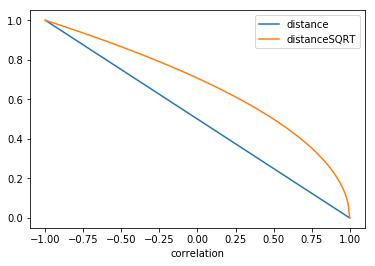

In [6]:
print('This is how the transformation works...')
transformDf = pd.DataFrame(index=range(-100,101,1)).reset_index().rename(columns={'index': 'correlation'})
transformDf['correlation'] = transformDf['correlation'] / 100
transformDf['distance'] = (1 - transformDf['correlation']) / 2
transformDf['distanceSQRT'] = ((1 - transformDf['correlation']) / 2) ** 0.5
transformDf.set_index('correlation').plot()

### Building Clusters

#### Define Linkage Method
In stock clustering, I prefer Average as a linkage method than others. (<a href="https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering">Popular Linkage Methods</a>) <br><br> Average is easy to understand and useful when we have standardized distance. It uses the arithmetic mean of distance when merging the clusters. The closer the two clusters, the faster the merge. Focusing on the proximity of clusters, instead of the number of objects within cluster. <br><br> Ward's Method is another popular method. It has fewer marginal point as it's less sensitive to outliers comparing to Average, so the number of objects within cluster will be more similar than using Average. <br><br> In Stock Clustering, Some stocks are clearly isolated from others. As a result, Average is a better method if we would like to filter out these isolated stocks when we're building clusters.

#### Building Dendrogram
It's not a compulsory step in the algorithm, but dendrogram is a very good tool to visualize hierarchical clustering and show how it works. <br><br> The concept is very simple. [<a href="https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html">hc.dendrogram</a>] will generate a dendrogram graph based on the linkage that derived from our adjusted distance. <br><br> Then, we could set a parameter as max distance to control the color threshold. It will put a line in the graph and highlight the clusters which have lower distances than the max distance.

In [397]:
# set Max Distance to 0.5
maxD = 0.5

In [400]:
def buildDendrogram(*args, **kwargs):
    maxD = kwargs.pop('max_d', None)
    if maxD and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = maxD
    annotateAbove = kwargs.pop('annotate_above', 0)

    data = hc.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Distance')
        for i, d, c in zip(data['icoord'], data['dcoord'], data['color_list']):
            y = 0.5 * sum(i[1:3])
            x = d[1]
            if y > annotateAbove:
                plt.plot(x, y, 'o', c=c, markersize=5)
                plt.annotate("%.3g" % x, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if maxD:
            plt.axvline(x=maxD, c='k')
    return data

def getDendrogram(returnDf, maxD):
    # format could be dynamic
    plt.style.use("seaborn-bright")
    plt.rcParams['figure.figsize'] = (15, 150)
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 6
    
    corr = ((1 - returnDf.corr()) / 2) ** 0.5
    corr = corr.fillna(0)
    corr_condensed = hc.distance.squareform(corr) 
    z = hc.linkage(corr_condensed, method='average')
    
    dendrogram = buildDendrogram(z, labels=corr.columns, 
                                 leaf_rotation=360., leaf_font_size=12, orientation='left', 
                                 max_d=maxD, annotate_above=0.1)

    plt.title('Hierarchical Clustering Dendrogram (S&P 500)')
    return plt.show()

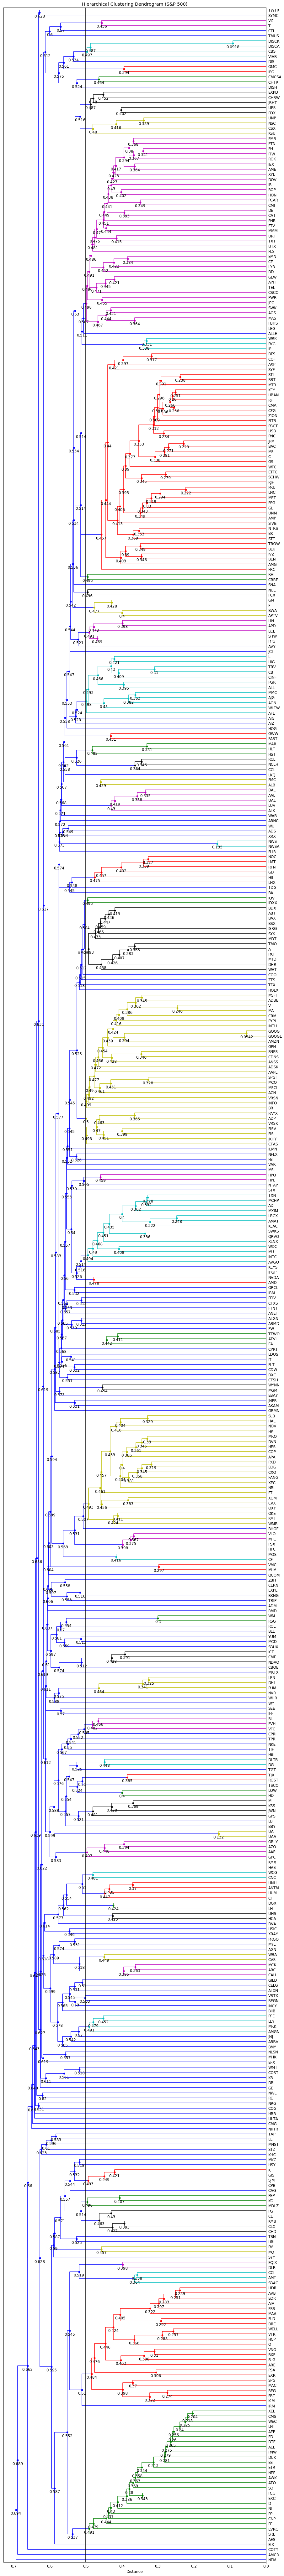

In [401]:
getDendrogram(returnDf=returnDf, maxD=maxD)

#### Existing Algorithms
I will elaborate two common existing algorithms from [<a href="https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.hierarchy.fcluster.html">hc.fcluster</a>]. <br><br> The first algorithm is the same as the above dendrogram [getClusterDfByDistance]. Observations in each flat cluster have no greater a cophenetic distance than max distance. I add an additional parameter to filter our clusters by minimum number of objects in cluster. For example, only the cluster with at least 2 objects and lower than 0.5 distance will be considered as a cluster. <br><br> The second algorithm is to create clusters based on number of clusters [getClusterDfByNumber]. The algorithm will find the minimum threshold in cophenetic distance, so that no more than the maximum number of clusters will be formed. For example, if you set the number of clusters as 11, the algorithm will provide you 11 clusters. 

##### Algorithm 1

In [185]:
# set max distance to 0.5
# set minimum number of objects in cluster to 2
maxD = 0.5
minNumberInCluster = 2

In [198]:
def getClusterDfByDistance(returnDf, maxD, minNumberInCluster):
    corr = ((1 - returnDf.corr()) / 2) ** 0.5
    corr = corr.fillna(0)
    corr_condensed = hc.distance.squareform(corr) 
    z = hc.linkage(corr_condensed, method='average')
    
    cluster = hc.fcluster(z, t=maxD, criterion='distance')
    clusterDf = pd.DataFrame(cluster).rename(columns={0: 'cluster'})
    clusterDf['ticker'] = corr.columns
    
    counter = Counter(cluster)
    clusterList = [clusterKey for clusterKey, clusterNum in counter.items() if clusterNum >= minNumberInCluster]
    
    clusterDf = clusterDf[clusterDf['cluster'].isin(clusterList)].copy()
    clusterDf['cluster'] = [clusterList.index(cluster) + 1 for cluster in clusterDf['cluster']]
    return clusterDf

In [324]:
clusterDf1 = getClusterDfByDistance(returnDf=returnDf, maxD=0.5, minNumberInCluster=minNumberInCluster)

In [325]:
clusterDf1.head()

,cluster,ticker
0,1,MMM
1,2,ABT
4,3,ACN
5,4,ATVI
6,3,ADBE


In [326]:
print('Algorithm 1')
print('Number of clusters: ' + str(len(set(clusterDf1['cluster']))))
print('Number of stocks have cluster: ' + str(clusterDf1['ticker'].count()))
print('OrderedDict: (Cluster, Number of Objects in Cluster)')
print(OrderedDict(Counter(clusterDf1['cluster']).most_common()))

Algorithm 1
Number of clusters: 58
Number of stocks have cluster: 363
OrderedDict: (Cluster, Number of Objects in Cluster)
OrderedDict([(7, 43), (1, 38), (3, 30), (13, 25), (12, 23), (20, 22), (18, 14), (2, 13), (8, 12), (42, 6), (9, 5), (10, 5), (23, 5), (31, 5), (6, 4), (17, 4), (19, 4), (21, 4), (24, 4), (27, 4), (34, 4), (36, 4), (41, 4), (46, 4), (4, 3), (15, 3), (16, 3), (25, 3), (32, 3), (33, 3), (45, 3), (49, 3), (55, 3), (5, 2), (11, 2), (14, 2), (22, 2), (26, 2), (28, 2), (29, 2), (30, 2), (35, 2), (37, 2), (38, 2), (39, 2), (40, 2), (43, 2), (44, 2), (47, 2), (48, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 2), (56, 2), (57, 2), (58, 2)])


##### Algorithm 2

In [214]:
# set number of cluster to 11
numberOfCluster = 11

In [215]:
def getClusterDfByNumber(returnDf, numberOfCluster):
    corr = ((1 - returnDf.corr()) / 2) ** 0.5
    corr = corr.fillna(0)
    corr_condensed = hc.distance.squareform(corr) 
    z = hc.linkage(corr_condensed, method='average')
    
    cluster = hc.fcluster(z, t=numberOfCluster, criterion='maxclust')
    clusterDf = pd.DataFrame(cluster).rename(columns={0: 'cluster'})
    clusterDf['ticker'] = corr.columns
    return clusterDf

In [216]:
clusterDf2 = getClusterDfByNumber(returnDf=returnDf, numberOfCluster=numberOfCluster)

In [217]:
clusterDf2.head()

,cluster,ticker
0,4,MMM
1,4,ABT
2,4,ABBV
3,4,ABMD
4,4,ACN


In [223]:
print('Algorithm 2')
print('Number of clusters: ' + str(len(set(clusterDf2['cluster']))))
print('Number of stocks have cluster: ' + str(clusterDf2['ticker'].count()))
print('OrderedDict: (Cluster, Number of Objects in Cluster)')
print(OrderedDict(Counter(clusterDf2['cluster']).most_common()))

Algorithm 2
Number of clusters: 11
Number of stocks have cluster: 498
OrderedDict: (Cluster, Number of Objects in Cluster)
OrderedDict([(4, 406), (1, 81), (2, 2), (3, 2), (10, 1), (5, 1), (7, 1), (9, 1), (8, 1), (11, 1), (6, 1)])


##### Algorithm 1 vs. Algorithm 2

Algorithm 1 is based on distance, which should be more accurate to measure the relationship within each cluster. We could consider it as a bottom-up approach. The drawback is that it can't control the number of clusters. Even though bottom-up approach is clear, it's also quite depending on the very first cluster. For example, if A,B has formed a cluster, C's distance with A,B is the average of distance(C,A) and distance (C,B) <br><br> Algorithm 2 is based on number, which is not very accurate to measure the relationship within each group. We could consider it as a top-down approach. You could find the distribution in our example is very skewed. It's quite sure that we have to break down the largest cluster in Algorithm 2. The skewed distribution is due to the Average linkage method. If we use Ward's method, the number of objects within each cluster will be more similar. However, we still can't control the distance within each group. <br><br> Obviously, Algorithm 1 is better than Algorithm 2 when we're doing stock clustering with Average as linkage method. <br><br> However, it doesn't means top-down approach is useless. It's helpful to filter out some isolated clusters, like some cluster with only a few objects. <br><br> Overall, Algorithm 1 is alright and Algorithm 2 is inappropriate for linkage method as Average. Other than that, could we have an alternative way to create cluster or even improve the existing methods?

#### Algorithm 3 (New Algorithm)

Our new alternative algorithm (Algorithm 3) is based on both the number of clusters and distance. <br><br> It's starting from top-down approach by splitting the stocks into 2 clusters, normally if we're using Average as linkage method, the cluster  will split like majority and minority. The minority part tends to be outlier or isolated cluster. However, it doesn't means separating two big clusters is impossible, so we need to set up a while for loops to monitor the separated clusters parallelly. <br><br> This split-to-two method will continue if the separated cluster's group average distance is greater than the max distance threshold. Otherwise, if the separated cluster has a group average distance lower than max distance and a larger number of objects than the minimum number of objects, then this separated cluster will become our confirmed cluster. The split process is doing parallelly. Our final clusters are all the confirmed clusters created from the while for loops process.<br><br> Below picture is an example of the algorithm. <br><br><br> <img src="algo.png">

Comparing with Algorithm 1, we could see some pros and cons in Algorithm 3. <br><br>Pros: <br><br>1. Less influenced by the first created cluster <br><br>2. Potentially include more influenced stocks in a cluster<br><br>Cons: <br><br>1. Outliers will affect the calculation of group average distance<br><br>2. Hard to visualize <br><br>Overall, we could see that Algorithm 1 is stricter than Algorithm 3. As Algorithm 3 will be affected by outliers in distance, so we must standardize the distance. In our case, the distance is standardized already. <br><br> To elaborate the outlier effect, let's say there have 11 stocks, 10 of them are very correlated, 1 of them is less correlated with others. If we use Algorithm 1, 10 of them will be grouped as a cluster first. Then, the distance of the remaining one stock to the cluster will be the average of distance of the remaining stock to each object in the cluster. If we use Algorithm 3, it will use the average of pairwise distance of these 11 stocks to decide whether it should be a cluster. So, in this case, there have certain probability that the less correlated stock will be included in the cluster under Algorithm 3 but not Algorithm 1. <br><br> That's why standardizing distance is important in Algorithm 3.

In [327]:
# set max group distance to 0.5
# set minimum number in cluster to 2
# set the x = 2 in split-to-x method <- default is 2
maxDistance = 0.5
minNumberInCluster = 2
clusterNumber = 2

In [328]:
def getClusterAttributes(corr, minNumberInCluster, maxDistance, clusterNumber):
    corrCondensed = hc.distance.squareform(corr)
    z = hc.linkage(corrCondensed, method='average')

    labels = hc.fcluster(z, t=clusterNumber, criterion='maxclust')
    counter = Counter(labels)
    
    labelsDf = pd.DataFrame(labels).rename(columns={0: 'cluster'})
    labelsDf['ticker'] = corr.index
    breakdownList = []
    dropList = []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        for clusterKey, clusterNum in counter.items():
            thisIdList = list(labelsDf[labelsDf['cluster'] == clusterKey]['ticker'])
            thisCorr = corr.loc[thisIdList, thisIdList].copy()
            thisGroupMean = hc.distance.squareform(thisCorr).mean()
            if thisGroupMean > maxDistance and clusterNum > minNumberInCluster:
                if len(counter.keys()) == clusterNumber:
                    breakdownList.append(clusterKey)
                else:
                    dropList.append(clusterKey)
            del thisIdList, thisCorr, thisGroupMean

    confirmList = [clusterKey for clusterKey, clusterNum in counter.items() if 
                   clusterNum >= minNumberInCluster and clusterKey not in breakdownList 
                   and clusterKey not in dropList]
    
    del corrCondensed, z, labels, counter
    return labelsDf, breakdownList, confirmList

def getClusterDfByNewAlgo(returnDf, maxDistance, minNumberInCluster, clusterNumber=2):
    masterLabelsDfList = []
    masterBreakdownList = []
    masterConfirmList = []
    layerNum = 1
    customClusterNum = 1

    # first layer
    corr = ((1 - returnDf.corr()) / 2) ** 0.5
    corr = corr.fillna(0)
    (globals()['labelsDf' + str(layerNum)],
     globals()['breakdownList' + str(layerNum)],
     globals()['confirmList' + str(layerNum)]) = getClusterAttributes(corr=corr,
                                                                      clusterNumber=clusterNumber,
                                                                      maxDistance=maxDistance,
                                                                      minNumberInCluster=minNumberInCluster)
    masterLabelsDfList.append('labelsDf' + str(layerNum))
    masterBreakdownList.append('breakdownList' + str(layerNum))
    masterConfirmList.append('confirmList' + str(layerNum))

    clusterDfList = []
    while masterBreakdownList != [] or masterConfirmList != []:
        # clear masterConfirmList first
        # using global variables to trigger master lists
        if masterConfirmList != []:
            for confirmListName in masterConfirmList:
                confirmListNumStr = confirmListName[11:]
                thisConfirmList = globals()[confirmListName]
                thisLabelsDf = globals()['labelsDf' + confirmListNumStr]
                for cluster in thisConfirmList:
                    thisTradeIdList = list(thisLabelsDf[thisLabelsDf['cluster'] == cluster]['ticker'])
                    thisClusterDf = pd.DataFrame.from_dict({'ticker': thisTradeIdList, 'cluster': customClusterNum})
                    clusterDfList.append(thisClusterDf)
                    customClusterNum += 1
                    del thisTradeIdList, thisClusterDf
                masterConfirmList.remove(confirmListName)
                del confirmListNumStr, thisConfirmList, thisLabelsDf, globals()[confirmListName]

        # handle masterBreakdownList
        if masterBreakdownList != []:
            for breakdownListName in masterBreakdownList:
                breakdownListNumStr = breakdownListName[13:]
                thisBreakdownList = globals()[breakdownListName]
                thisLabelsDf = globals()['labelsDf' + breakdownListNumStr]
                breakdownClusterNum = 1
                layerNum += 1
                for cluster in thisBreakdownList:
                    thisTradeIdList = list(thisLabelsDf[thisLabelsDf['cluster'] == cluster]['ticker'])
                    thisCorr = corr.loc[thisTradeIdList, thisTradeIdList]
                    thisNumStr = str(layerNum) + '_' + str(breakdownClusterNum)
                    (globals()['labelsDf' + thisNumStr],
                     globals()['breakdownList' + thisNumStr],
                     globals()['confirmList' + thisNumStr]) = getClusterAttributes(corr=thisCorr,
                                                                                   clusterNumber=clusterNumber,
                                                                                   maxDistance=maxDistance,
                                                                                   minNumberInCluster=minNumberInCluster)
                    masterLabelsDfList.append('labelsDf' + thisNumStr)
                    masterBreakdownList.append('breakdownList' + thisNumStr)
                    masterConfirmList.append('confirmList' + thisNumStr)
                    breakdownClusterNum += 1
                    del thisTradeIdList, thisCorr, thisNumStr
                masterBreakdownList.remove(breakdownListName)
                del breakdownListNumStr, thisBreakdownList, thisLabelsDf, breakdownClusterNum, globals()[breakdownListName]
                continue

    clusterDf = pd.concat(clusterDfList)
    for dfName in masterLabelsDfList:
        del globals()[dfName]
    del masterBreakdownList, masterConfirmList, layerNum, customClusterNum, corr, clusterDfList, masterLabelsDfList
    return clusterDf

In [347]:
clusterDf3 = getClusterDfByNewAlgo(returnDf=returnDf, maxDistance=maxDistance, minNumberInCluster=minNumberInCluster)

In [348]:
clusterDf3.head()

,ticker,cluster
0,AES,1
1,ARE,1
2,LNT,1
3,AEE,1
4,AEP,1


In [349]:
print('Algorithm 3')
print('Number of clusters: ' + str(len(set(clusterDf3['cluster']))))
print('Number of stocks have cluster: ' + str(clusterDf3['ticker'].count()))
print('OrderedDict: (Cluster, Number of Objects in Cluster)')
print(OrderedDict(Counter(clusterDf3['cluster']).most_common()))

Algorithm 3
Number of clusters: 48
Number of stocks have cluster: 415
OrderedDict: (Cluster, Number of Objects in Cluster)
OrderedDict([(47, 110), (1, 56), (42, 30), (30, 29), (37, 22), (41, 19), (48, 14), (5, 8), (33, 8), (45, 7), (22, 6), (10, 5), (11, 5), (13, 5), (15, 5), (24, 5), (26, 5), (43, 5), (8, 4), (18, 4), (21, 4), (27, 4), (19, 3), (25, 3), (34, 3), (2, 2), (3, 2), (4, 2), (6, 2), (7, 2), (9, 2), (12, 2), (14, 2), (16, 2), (17, 2), (20, 2), (23, 2), (28, 2), (29, 2), (31, 2), (32, 2), (35, 2), (36, 2), (38, 2), (39, 2), (40, 2), (44, 2), (46, 2)])


##### Difference in Distance (Algorithm 1 vs Algorithm 3)

I chose 0.5 as a distance but it's a bit hindsight because I picked it from the dendrogram. Obviously, 0.5 is not fit to Algorithm 3 because it's less stricter than Algorithm 1, which is the algorithm used in the dendrogram. As a result, I slightly lower the distance in Algorithm 3 for comparison. 

In [379]:
# set max group distance to 0.47
# set minimum number in cluster to 2
# set the x = 2 in split-to-x method <- default is 2
maxDistance = 0.47
minNumberInCluster = 2
clusterNumber = 2

In [380]:
clusterDf4 = getClusterDfByNewAlgo(returnDf=returnDf, maxDistance=maxDistance, minNumberInCluster=minNumberInCluster)

In [382]:
print('Algorithm 3 (Adjust Distance)')
print('Number of clusters: ' + str(len(set(clusterDf4['cluster']))))
print('Number of stocks have cluster: ' + str(clusterDf4['ticker'].count()))
print('OrderedDict: (Cluster, Number of Objects in Cluster)')
print(OrderedDict(Counter(clusterDf4['cluster']).most_common()))

Algorithm 3 (Adjust Distance)
Number of clusters: 67
Number of stocks have cluster: 381
OrderedDict: (Cluster, Number of Objects in Cluster)
OrderedDict([(56, 43), (61, 33), (27, 27), (1, 26), (2, 24), (53, 23), (44, 16), (59, 12), (34, 7), (54, 7), (66, 7), (67, 6), (3, 5), (6, 5), (15, 5), (45, 5), (62, 5), (10, 4), (17, 4), (23, 4), (25, 4), (30, 4), (36, 4), (51, 4), (63, 4), (7, 3), (13, 3), (32, 3), (35, 3), (39, 3), (47, 3), (48, 3), (57, 3), (60, 3), (4, 2), (5, 2), (8, 2), (9, 2), (11, 2), (12, 2), (14, 2), (16, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (24, 2), (26, 2), (28, 2), (29, 2), (31, 2), (33, 2), (37, 2), (38, 2), (40, 2), (41, 2), (42, 2), (43, 2), (46, 2), (49, 2), (50, 2), (52, 2), (55, 2), (58, 2), (64, 2), (65, 2)])


In [389]:
compareDf = pd.DataFrame.from_dict({'ticker': returnDf.columns})

In [390]:
compareDf = pd.merge(compareDf, clusterDf1.rename(columns={'cluster': 'cluster1'}), on=['ticker'], how='left')
compareDf = pd.merge(compareDf, clusterDf4.rename(columns={'cluster': 'cluster3'}), on=['ticker'], how='left')

In [393]:
compareDf.sort_values(['cluster3', 'cluster1']).head(30)

,ticker,cluster1,cluster3
23,LNT,13.0,1.0
30,AEE,13.0,1.0
32,AEP,13.0,1.0
36,AWK,13.0,1.0
57,ATO,13.0,1.0
100,CNP,13.0,1.0
120,CMS,13.0,1.0
129,ED,13.0,1.0
156,D,13.0,1.0
158,DTE,13.0,1.0


#### Conclusion

In summary, Algorithm 1 and Algorithm 3 are both work for stock clustering with average as a linkage method. Above comparison did show some difference between these 2 algorithms. <br><br> For example, AES was excluded in cluster1 because it's slightly far from the big group according to the dendrogram. However, it's included in cluster3 within the same group. A potential reason could be AES is close to some stocks in that cluster but not all the stocks in that cluster. So, when we're calculating a group average, it has more chance to be included in that cluster than just calculate the averge distance of AES with each stock in that cluster. <br><br> It has no clear conclusion to show that Algorithm 3 is far better than Algorithm 1, but having an alternative dynamic algorithm is still good. (they're sharing the same parameters)<br><br>Being dynamic is also important because the use cases of stock clustering are quite diverse. In hedging, we care the distance between each stock within the cluster, but not the number of stocks in cluster. However, in cluster neutral factor model, we care the distance and also the number of stocks in cluster. It would be even better if the coverage is good. Also, different universe could have different characteristic. <br><br> So, in some cases, Algorithm 3 could be better, while Algorithm 1 could be better in some other cases.